Title: Mercedes-Benz Greener Manufacturing - Kaggle Competition
Date: 2017-06-29
Author: Dario Arcos-Díaz

# Mercedes-Benz Greener Manufacturing - Kaggle Competition

In this post, I analyze the data from the Mercedes-Benz Kaggle Competition, which aims to better predict the time spent in quality testing for different car configurations. The idea is that if the company would then be able to improve the planning of the tests and reduce the amount of CO2 emmitted from only testing their cars. With this in mind, let's take a look!


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
% matplotlib inline
import seaborn as sns
sns.set_palette('muted')
import time
import os

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils import check_array
from sklearn.linear_model import LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# Data description

1234567890123456789012345678901234567890123456789012345678901234567890123456789

The data comes in two files that can be imported into pandas DataFrames.

In [ ]:
# load train and test data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

print('Training data consists of ',
      '{0} examples and {1} features'.format(train.shape[0], train.shape[1]),
      'Testing data consists of ',
      '{0} examples and {1} features'.format(test.shape[0], test.shape[1]))

The feature names in both data sets are exactly the same. The training data contains the extra target variable 'y'.

The feature set consists of:
- ID variable
- y target variable
- 9 categorical features X0-X9
- XXX binary features X10-XXXX

This means that we will have to handle categorical and binary features differently.

In [ ]:
# encode categorical data
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))
# get X and y for training
X_train = train.drop('y', axis=1)
y_train = train['y']

# get X for testing
X_test = test
X_train.shape, y_train.shape, X_test.shape

# Feature engineering

In [6]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(X_train)
tsvd_results_test = tsvd.transform(X_test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(X_train)
pca2_results_test = pca.transform(X_test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(X_train)
ica2_results_test = ica.transform(X_test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(X_train)
grp_results_test = grp.transform(X_test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(X_train)
srp_results_test = srp.transform(X_test)

#save columns list before adding the decomposition components

usable_columns = list(set(train.columns) - set(['y']))

# create empty dataframes to capture extra features
extra_features_train = pd.DataFrame()
extra_features_test = pd.DataFrame()

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    extra_features_train['pca_' + str(i)] = pca2_results_train[:, i - 1]
    extra_features_test['pca_' + str(i)] = pca2_results_test[:, i - 1]

    extra_features_train['ica_' + str(i)] = ica2_results_train[:, i - 1]
    extra_features_test['ica_' + str(i)] = ica2_results_test[:, i - 1]

    extra_features_train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    extra_features_test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    extra_features_train['grp_' + str(i)] = grp_results_train[:, i - 1]
    extra_features_test['grp_' + str(i)] = grp_results_test[:, i - 1]

    extra_features_train['srp_' + str(i)] = srp_results_train[:, i - 1]
    extra_features_test['srp_' + str(i)] = srp_results_test[:, i - 1]

extra_features_train.shape, extra_features_test.shape

((4209, 60), (4209, 60))

# Stacked model

In [4]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prediction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [7]:
stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, 
                                                          max_features=0.55, min_samples_leaf=18, min_samples_split=14, 
                                                          subsample=0.7)),
    LassoLarsCV()
)

# stacked model is trained without the extra features
stacked_pipeline.fit(X_train, y_train)
y_pred1 = stacked_pipeline.predict(X_test)

In [8]:
# evaluate pipeline
# t0 = time.time()
# seed = 7
# kfold = KFold(n_splits=10, random_state=seed)
# results = cross_val_score(stacked_pipeline, X_train, y_train, cv=kfold)
# print(results.mean())
# print("Done: {:.1f} s".format(time.time() - t0))

# 0.575790611694
# Done: 47.7 s

# XGB Model

In [9]:
X_train = np.hstack((X_train, extra_features_train))
X_test = np.hstack((X_test, extra_features_test))

In [23]:
# train XGB
print('Training')
t0 = time.time()
num_round = 1250
eta = 0.0045
param = {'n_trees': 520, 
         'max_depth':4, 
         'min_child_weight':4,
         'eta':eta, 'learning_rate':eta,
         'silent':1, 'objective':'reg:linear', 
         'subsample':0.93,# 'colsample_bytree':0.5, 
         'n_estimators':num_round, 'num_boost_round':num_round}
dtrain = xgb.DMatrix(data=X_train, label=y_train)
#watchlist  = [(dtest,'test'), (dtrain,'train')]
xgb_model = xgb.train(param, dtrain, num_round)#, early_stopping_rounds=5)
print("Done: {:.1f} s".format(time.time() - t0))
os.system('say "finished running code"')

Training


Done: 137.3 s


0

In [23]:
# evaluate pipeline
t0 = time.time()
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(xgb.XGBRegressor(**param), X_train, y_train, cv=kfold) # xgb_model in sklearn wrapper
print(results.mean())
print("Done: {:.1f} s".format(time.time() - t0))
os.system('say "finished running code"')

# 0.573627668125 for xgb_model
# Done: 76.6 s

# 0.573665697336 # xgb_model2
# Done: 1384.7 s

0.568613029431
Done: 1274.8 s


0

# Cross validation

In [20]:
def evalcoef(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

# train XGB
print('Cross validating')
t0 = time.time()
# param same as for training
# dtrain = xgb.DMatrix(data=X_train, label=y_train)
# watchlist  = [(dtest,'test'), (dtrain,'train')]
num_folds = 10
xgb_modelcv = xgb.cv(param, dtrain, num_round, num_folds, feval=evalcoef)#, early_stopping_rounds=5)
print("Done: {:.1f} s".format(time.time() - t0))
os.system('say "finished running code"')

Cross validating


Done: 543.7 s


0

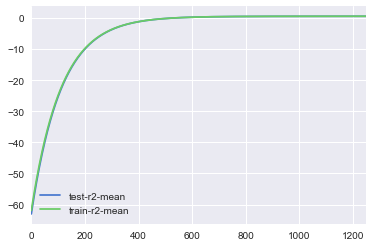

In [21]:
xgb_modelcv[['test-r2-mean', 'train-r2-mean']].plot()
#plt.xlim(400,500)

# Make test predictions

In [24]:
# get predictions from model
dtest = xgb.DMatrix(data=X_test)
y_pred2 = xgb_model.predict(dtest)

In [25]:
# average predictions from stacked model and xgb
y_pred = y_pred2*0.75 + y_pred1*0.25

In [26]:
# create submission csv file
dirname = 'output'
count = len(os.listdir(os.path.join(os.getcwd(), dirname))) + 1
filename = 'sub' + str(count) + '_xgb' + '_maxdepth' + str(param['max_depth']) + '_eta' + str(param['eta']) + \
           '_numround' + str(num_round) + '.csv'
pd.concat([test.ID, pd.Series(y_pred)], axis=1).to_csv(dirname + '/' + filename,
                                                       header=['ID', 'y'], index=False)